**Note:** This notebook contains the complete code used in the accompanying project report on PCA simulations. It is intended as a supplementary resource for reproducibility and validation. For detailed explanations and interpretations, please refer to the written project thesis.


# PCA simulation

## Principal Component Analysis on Transformed and Lognormal Data

This notebook explores the behavior of Principal Component Analysis (PCA) applied to data generated from different distributions and transformations. We simulate latent variables `A` and `B` from normal or lognormal distributions, apply linear transformations to produce observable variables `X` and `Y`, and then apply PCA to:

- the transformed data directly
- logarithmized versions of the data (for normalization)
- quantile-filtered subsets of the data to study the impact of outliers

We also analyze the explained variance of PCA components and how they behave under varying quantiles and random seeds, highlighting the robustness and limitations of PCA in the presence of skewed distributions.


## Package import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm, lognorm

## 2D data 

In [2]:
 # Generate latent variables a and b from normal distribution
def generate_normal_a_b(mu_a, sigma_a, mu_b, sigma_b, n):
    rng = np.random.default_rng(23)
    a = rng.normal(mu_a, sigma_a, n)
    b = rng.normal(mu_b, sigma_b, n)
    return a, b

# Apply rotation (by angle phi) to a and b to produce x and y
def calculate_x_y(a, b, phi):
    x = np.cos(phi) * a + np.sin(phi) * b
    y = - np.sin(phi) * a + np.cos(phi) * b
    return x, y

# Perform PCA on 2D data composed of x and y, returns trained PCA object
def perform_pca(x, y):
    data = np.array([x, y]).T
    pca = PCA(n_components=2)
    pca.fit(data)
    return pca

# Plot original data (a, b), transformed data (x, y), and a comparison of both
def plot_original_transformed(a, b, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

    # latent variables a and b
    axes[0].scatter(a, b, alpha=0.5, s=10)
    axes[0].set_xlabel("a")
    axes[0].set_ylabel("b")
    axes[0].set_title("Original distribution of the \n data before transformation")
    axes[0].grid(True)
    axes[0].axis("equal")  

    # transformed: x and y
    axes[1].scatter(x, y, alpha=0.5, s=10, c="r")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"Distribution of the data \n after rotation of 30°")  
    axes[1].grid(True)
    axes[1].axis("equal")

    # compare
    axes[2].scatter(a, b, alpha=0.5, s=10)
    axes[2].scatter(x, y, alpha=0.5, s=10, c="r")
    axes[2].set_xlabel("a/x")
    axes[2].set_ylabel("b/y")
    axes[2].set_title("Comparison between the original data a and b \n and the transformed data x and y")
    axes[2].grid(True)
    axes[2].axis("equal") 
    axes[2].legend(["Original (a, b)", "Transformed (x, y)"], loc=2)

    plt.tight_layout() 
    plt.show()
    


In [3]:
MU_A = 1
SIGMA_A = 1
MU_B = 2
SIGMA_B = 2
N = 1000
PHI_GRAD = 30

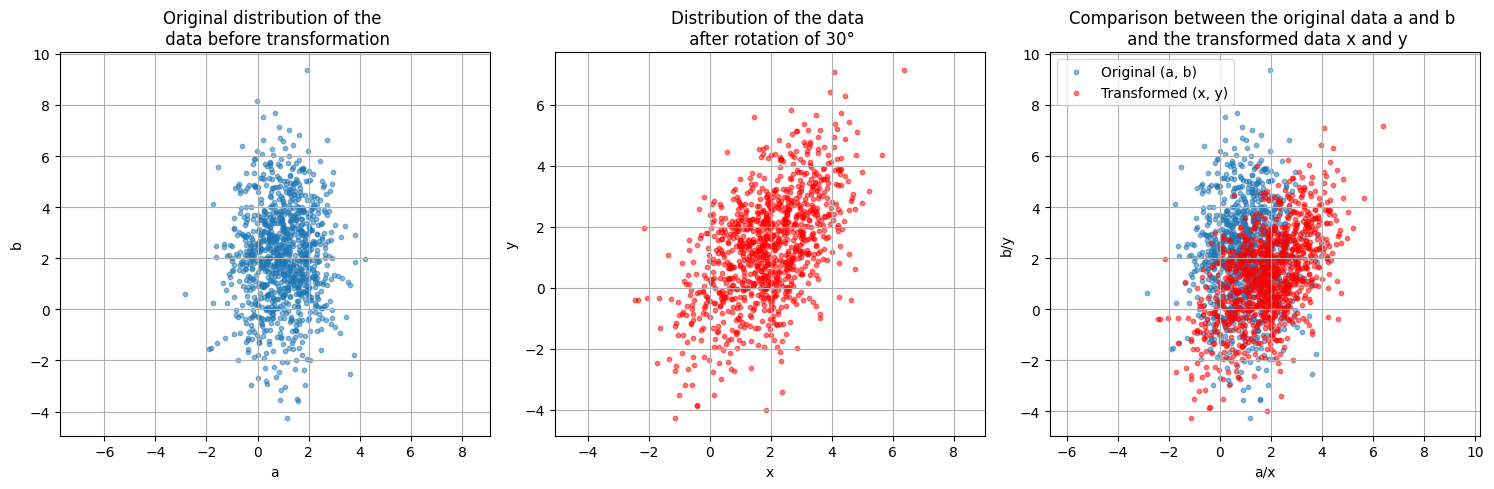

In [4]:
a_2d, b_2d = generate_normal_a_b(MU_A, SIGMA_A, MU_B, SIGMA_B, N) 
phi = np.radians(PHI_GRAD) # degree in radiant
x_2d, y_2d = calculate_x_y(a_2d, b_2d, phi) 
pca_2d = perform_pca(x_2d, y_2d)
plot_original_transformed(a_2d, b_2d, x_2d, y_2d)

The plot illustrates how the original random variables a and b change after a linear transformation through rotation (with $\phi = 30^\degree$). Since a and b are drawn from normal distributions with different standard deviations, the initial point cloud (left) appears elliptically distributed. The transformation using X and Y rotates this ellipse by the angle $\phi$. It is also evident that b has a larger standard deviation than a, as the spread in that direction is more pronounced. Importantly, the shape of the distribution does not change—only its position and orientation. The variance along each axis remains unchanged.

In [5]:
# Center the data and project it onto the PCA axes
def centralizing_data(x, y, pca):
    x_central = x - pca.mean_[0]
    y_central = y - pca.mean_[1]
    xy_array = np.array([x_central, y_central]).T

    # isolate principal components
    e_pc1 = pca.components_[0]
    e_pc2 = pca.components_[1]

    # transformation matrix
    transformation_matrix = ([
        [e_pc1[0], e_pc2[0]],
        [e_pc1[1], e_pc2[1]]
        ])
    
    skalar = np.dot(xy_array, transformation_matrix)

    return skalar

def plot_original_transformed_PCA(a, b, x, y, skalar, pca):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    letters = ['a', 'b', 'c']
    positions = [(0.04, 0.96), (1.03, 0.96), (2.02, 0.96)] 
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=22, fontweight='bold')

    for ax in axes:
        ax.set_xticks(np.arange(-10, 11, 2)) 
        ax.set_yticks(np.arange(-10, 11, 2)) 
        ax.grid(True)

    # latent variables A and B
    axes[0].scatter(a, b, alpha=0.5, s=10)
    axes[0].axhline(0, color='dimgray', linestyle='-', linewidth=1)
    axes[0].axvline(0, color='dimgray', linestyle='-', linewidth=1)
    axes[0].set_xlabel("A", fontsize="18")
    axes[0].set_ylabel("B", fontsize="18")
    axes[0].grid(True)
    axes[0].set_xlim(-6.5, 8)
    axes[0].set_ylim(-4.5, 10)
    axes[0].tick_params(axis='both', labelsize=18)

    # transformed data x and y
    axes[1].scatter(x, y, alpha=0.5, s=10)
    for i, (length, vector) in enumerate(zip(pca.explained_variance_, pca.components_)):
        v = vector * np.sqrt(length) * 3
        axes[1].quiver(pca.mean_[0], pca.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color="firebrick")
        label = "PC1" if i == 0 else "PC2"
        axes[1].text(pca.mean_[0] + v[0], pca.mean_[1] + v[1], label, color='firebrick', fontsize=17, verticalalignment='bottom', fontweight="bold")
    axes[1].axhline(0, color='dimgray', linestyle='-', linewidth=1)
    axes[1].axvline(0, color='dimgray', linestyle='-', linewidth=1)   
    axes[1].set_xlabel("X", fontsize="18")
    axes[1].set_ylabel("Y", fontsize="18")
    axes[1].grid(True)
    axes[1].set_xlim(-6.5, 8)
    axes[1].set_ylim(-4.5, 10)
    axes[1].tick_params(axis="both", labelsize=18)

    # PC1 and PC2
    axes[2].scatter(skalar[:, 0], skalar[:, 1], alpha=0.5, s=10)
    axes[2].axhline(0, color='dimgray', linestyle='-', linewidth=1)
    axes[2].axvline(0, color='dimgray', linestyle='-', linewidth=1)
    axes[2].set_xlabel("PC1", fontsize="18")
    axes[2].set_ylabel("PC2", fontsize="18")
    axes[2].grid(True)
    axes[2].set_xlim(-6.5, 8)
    axes[2].set_ylim(-4.5, 10)
    axes[2].tick_params(axis="both", labelsize=18)

    # inset: explained variance ratio
    axins3 = inset_axes(axes[2], width=1.5, height=1.5, loc='upper right', bbox_to_anchor=(0.99, 0.95), bbox_transform=axes[2].transAxes)
    axins3.bar([1, 2], pca.explained_variance_ratio_, color='gray')
    axins3.set_xticks([1, 2])
    axins3.set_xticklabels(['PC1', 'PC2'], fontsize=12)
    axins3.set_yticks([0.0, 0.5, 1.0])
    axins3.set_yticklabels(['0', '0.5', '1.0'], fontsize=12)
    axins3.set_title("EVR", fontsize=15)
    axins3.tick_params(axis='both', labelsize="16")


    plt.tight_layout()
    plt.savefig("../../latex/figures/2_PCA_on_2dData.pdf")
    plt.savefig("../../latex/pictures/2_PCA_on_2dData.png", dpi=400, bbox_inches="tight")
    plt.show()

C:\Users\emmiw\AppData\Local\Temp\ipykernel_26448\783744521.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


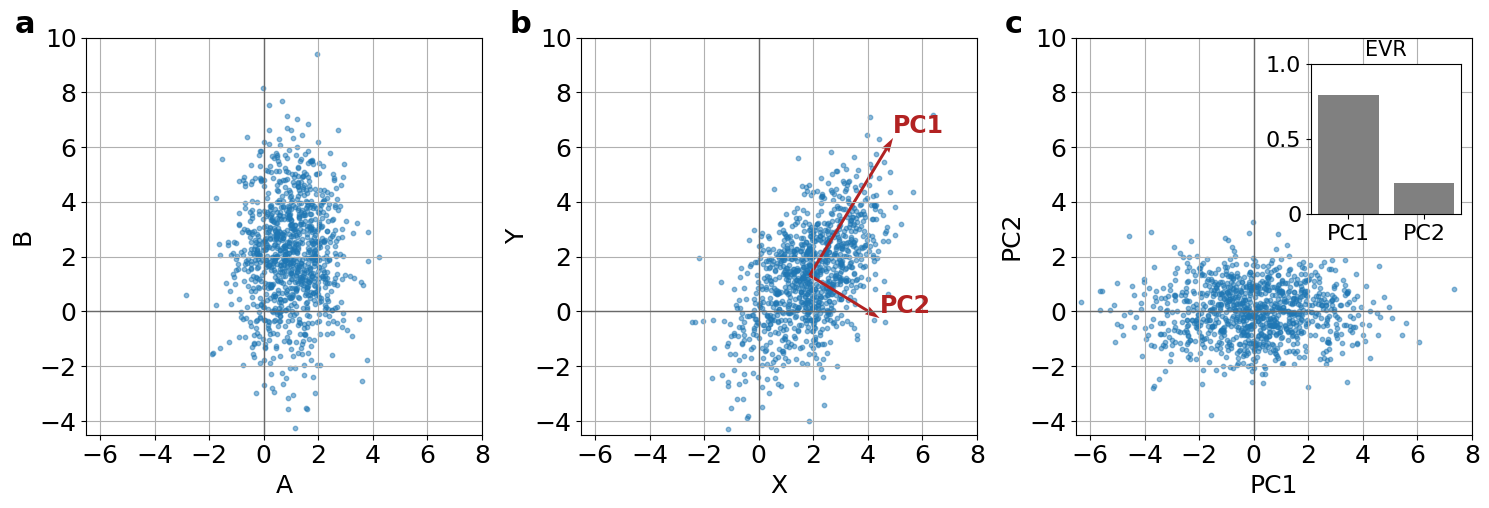

In [6]:
skalar_2d = centralizing_data(x_2d, y_2d, pca_2d)
plot_original_transformed_PCA(a_2d, b_2d, x_2d, y_2d, skalar_2d, pca_2d)

## 3D data

In [7]:
# a and b can be used from the 2D data generation
# transformation: x, y and z by a, b, angle phi and angle theta
def calculate_x_y(a, b, phi, theta):
    x = np.cos(phi) * a + np.sin(phi) * b
    y_input = - np.sin(phi) * a + np.cos(phi) * b
    y = np.cos(theta) * y_input
    z = np.sin(theta) * y_input

    return x, y, z

# PCA on x, y and z
def perform_pca(x, y, z):
    data = np.array([x, y, z]).T
    pca = PCA(n_components=3)
    pca.fit(data)
    return pca

# centralizing the data
def centralizing_data(x, y, z, pca):
    x_central = x - pca.mean_[0]
    y_central = y - pca.mean_[1]
    z_central = z - pca.mean_[2]
    xyz_array = np.column_stack((x_central, y_central, z_central))

    transformation_matrix = pca.components_.T
    skalar = np.dot(xyz_array, transformation_matrix)

    return skalar

def plot_original_transformed_PCA_3d(a, b, x, y, z, skalar, pca):
    fig = plt.figure(figsize=(15, 5))

    letters = ['a', 'b', 'c']
    positions = [(0.04, 0.96), (1.1, 0.96), (2.1, 0.96)]  
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=22, fontweight='bold')

    # latent variables a and b
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(a, b, alpha=0.5, s=10)
    ax1.axhline(0, color='gray', linestyle='-', linewidth=1)
    ax1.axvline(0, color='gray', linestyle='-', linewidth=1)
    ax1.set_xlabel("A", size=18)
    ax1.set_ylabel("B", size=18)
    ax1.grid(True)
    ax1.set_xlim(-6.5, 8)
    ax1.set_ylim(-4.5, 10)
    ax1.set_xticks(np.arange(-6, 9, 2))
    ax1.set_yticks(np.arange(-4, 11, 2))
    ax1.tick_params(axis='both', labelsize=18)

    # transformed data x, y and z
    ax2 = fig.add_subplot(1, 3, 2, projection="3d")
    ax2.scatter(x, y, z, alpha=0.3, s=10)
    for i, (length, vector) in enumerate(zip(pca.explained_variance_, pca.components_)):
        v = vector * np.sqrt(length) * 3  # vector scale
        ax2.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2],
                v[0], v[1], v[2], length=1, normalize=False, color="firebrick")
        
        # vector label
        if i < 2:  
            label = f"PC{i + 1}" 
            ax2.text(pca.mean_[0] + v[0], 
                     pca.mean_[1] + v[1], 
                     pca.mean_[2] + v[2], 
                     label, color="firebrick", fontsize=17, fontweight="bold")
    ax2.set_xlabel("X", size=18, labelpad=10)
    ax2.set_ylabel("Y", size=18, labelpad=10)
    ax2.set_zlabel("Z", size=18, labelpad=10)
    ax2.grid(True)
    ax2.tick_params(axis="both", labelsize=16)

    # PC1 and PC2
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(skalar[:, 0], skalar[:, 1], alpha=0.5, s=10)
    ax3.axhline(0, color='gray', linestyle='-', linewidth=1)
    ax3.axvline(0, color='gray', linestyle='-', linewidth=1)
    ax3.set_xlabel("PC1", size=18)
    ax3.set_ylabel("PC2", size=18, labelpad=0)
    ax3.grid(True)
    ax3.set_xlim(-6.5, 8)
    ax3.set_ylim(-4.5, 10)
    ax3.set_xticks(np.arange(-6, 9, 2))
    ax3.set_yticks(np.arange(-4, 11, 2))
    ax3.tick_params(axis='both', labelsize=18)

    # Inset: explained variance ratio
    axins = inset_axes(ax3, width=1.5, height=1.5, loc='upper right', bbox_to_anchor=(0.99, 0.95), bbox_transform=ax3.transAxes)
    axins.bar([1, 2, 3], pca.explained_variance_ratio_, color='gray')
    axins.set_xticks([1, 2, 3])
    axins.set_xticklabels(['PC1', 'PC2', 'PC3'], fontsize=16)
    axins.set_yticks([0.0, 0.5, 1.0])
    axins.set_yticklabels(['0', '0.5', '1.0'], fontsize=16)
    axins.set_title("EVR", fontsize=15)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4) 
    plt.savefig("../../latex/figures/3_PCA_on_3dData.pdf")
    plt.savefig("../../latex/pictures/3_PCA_on_3dData.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("Explained variance ratio:\n", pca.explained_variance_ratio_)
    print("Principal components:\n", pca.components_)
    print("Singular values:\n", pca.singular_values_)

C:\Users\emmiw\AppData\Local\Temp\ipykernel_26448\1002296928.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


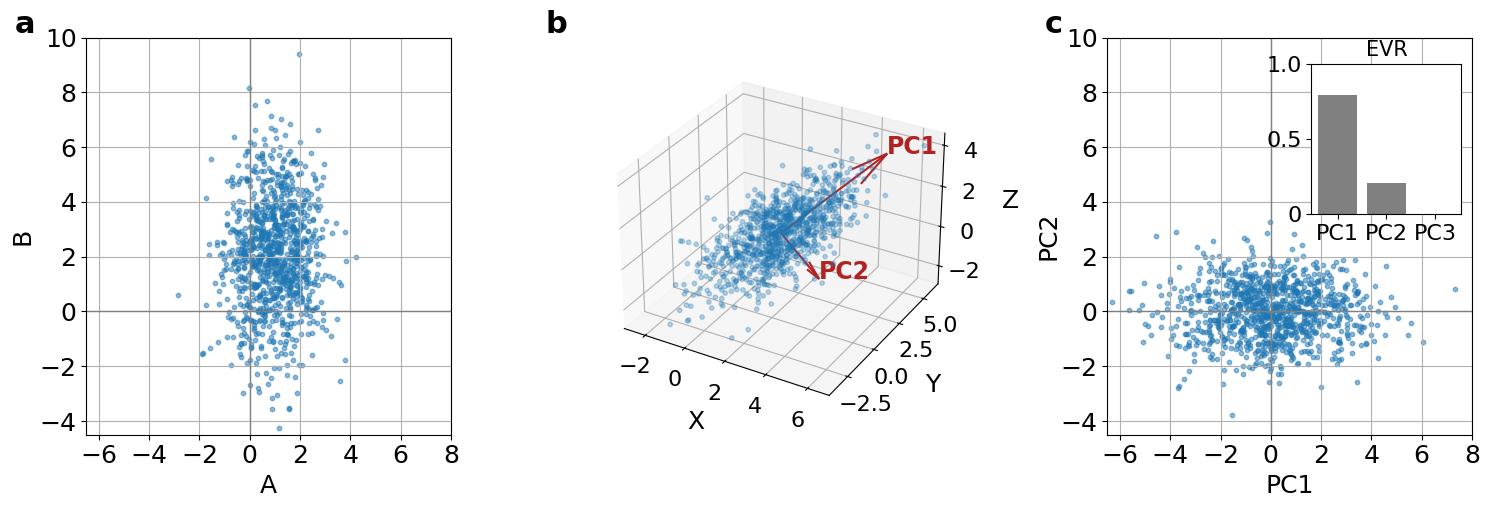

Explained variance ratio:
 [0.7931752 0.2068248 0.       ]
Principal components:
 [[ 5.19971436e-01  6.99706282e-01  4.89939613e-01]
 [ 8.54183649e-01 -4.25935665e-01 -2.98243363e-01]
 [ 1.20254366e-15 -5.73576436e-01  8.19152044e-01]]
Singular values:
 [61.89494474 31.60617335  0.        ]


In [8]:
# generate missing data
THETA_GRAD = 35
theta = np.radians(THETA_GRAD)

# transform data
x_3d, y_3d, z_3d = calculate_x_y(a_2d, b_2d, phi, theta)

# PCA
pca_3d = perform_pca(x_3d, y_3d, z_3d)
skalar_3d = centralizing_data(x_3d, y_3d, z_3d, pca_3d)

# plot
plot_original_transformed_PCA_3d(a_2d, b_2d, x_3d, y_3d, z_3d, skalar_3d, pca_3d)

## Lognormal data

### logarithmize lognormal data to generate normal distribution

In [9]:
 # a und b lognormal
def generate_A_B(mu_a, sigma_a, mu_b, sigma_b, n, seed):
    rng = np.random.default_rng(seed)
    A = rng.lognormal(mu_a, sigma_a, n)
    B = rng.lognormal(mu_b, sigma_b, n)
    return A, B

# lnX and lnY by a, b and phi; logarithmize to generate normal distribution
def logarithmize_X_Y(A, B, a, b, phi):
    X_norm = a * np.cos(phi) * np.log(A) + b * np.sin(phi) * np.log(B)
    Y_norm = -a * np.sin(phi) * np.log(A) + b * np.cos(phi) * np.log(B)
    return X_norm, Y_norm

# PCA
def perform_pca(ln_X, ln_Y):
    data = np.array([ln_X, ln_Y]).T
    pca = PCA(n_components=2)
    pca.fit(data)
    return data, pca

# plot
def plot_pca_results(X, Y, pca, xlabel='X', ylabel='Y', title='PCA Plot'):
    print("Explained variance ratio:\n", pca.explained_variance_ratio_)
    print("Principal components:\n", pca.components_)
    print("Singular values:\n", pca.singular_values_)

    plt.figure(figsize=(6, 6))
    plt.scatter(X, Y, alpha=0.5)
    for i, (length, vector) in enumerate(zip(pca.explained_variance_, pca.components_)):
        v = vector * np.sqrt(length) * 3
        plt.quiver(pca.mean_[0], pca.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color='firebrick')
        label = f"PC{i+1}"
        plt.text(pca.mean_[0] + v[0], pca.mean_[1] + v[1], label, color='r', fontsize=12, verticalalignment='bottom')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.show()



In [10]:
MU_A, SIGMA_A, MU_B, SIGMA_B = 1, 1, 1.3, 1.3
a, b = 1, 1
N = 1000
PHI_GRAD = 30
SEED = 231003

Explained variance ratio:
 [0.63448801 0.36551199]
Principal components:
 [[ 0.54754039  0.83677926]
 [ 0.83677926 -0.54754039]]
Singular values:
 [42.45986798 32.2268415 ]


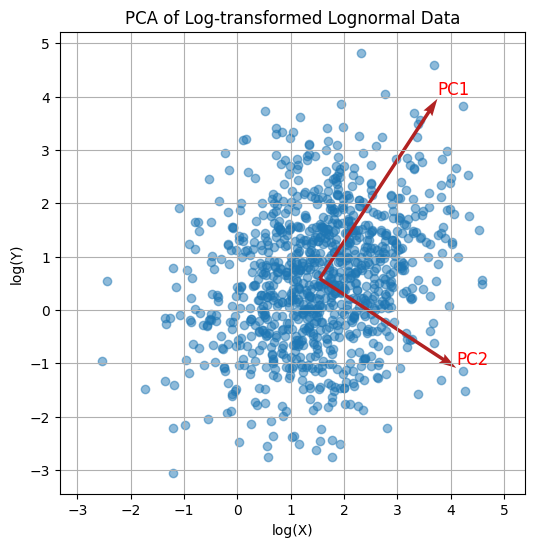

In [11]:
A_log, B_log = generate_A_B(MU_A, SIGMA_A, MU_B, SIGMA_B, N, SEED)
phi = np.radians(PHI_GRAD)
X_norm, Y_norm = logarithmize_X_Y(A_log, B_log, a, b, phi) 
data_norm, pca_norm = perform_pca(X_norm, Y_norm) 
plot_pca_results(X_norm, Y_norm, pca_norm, xlabel='log(X)', ylabel='log(Y)', title='PCA of Log-transformed Lognormal Data')

### lognormal distributed data remains lognormal

In [12]:
# X and Y, lognormally distributed
def generate_X_Y(A, B, a, b, phi):
    X_log = A ** (a * np.cos(phi)) * B ** (b * np.sin(phi))
    Y_log = A ** (-a * np.sin(phi)) * B ** (b * np.cos(phi))
    return X_log, Y_log

Explained variance ratio:
 [0.71618894 0.28381106]
Principal components:
 [[ 0.98469034  0.17431276]
 [-0.17431276  0.98469034]]
Singular values:
 [370.02518981 232.93360113]


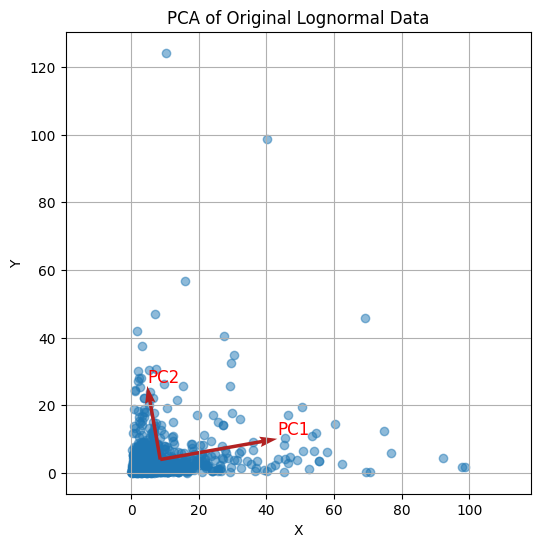

In [13]:
X_log, Y_log = generate_X_Y(A_log, B_log, a, b, phi) 
data_log, pca_log = perform_pca(X_log, Y_log) 
plot_pca_results(X_log, Y_log, pca_log, xlabel='X', ylabel='Y', title='PCA of Original Lognormal Data')

#### Using the 0.9 quantile: Outliers are removed to assess their influence on the PCA


In [14]:
def calculate_quantil(data_lognormal, quantil):
    magnitudes = np.linalg.norm(data_lognormal, axis=1)
    treshold = np.quantile(magnitudes, quantil)
    data_quantil = data_lognormal[magnitudes <= treshold]
    # print(f"Anzahl der verbleibenden Datenpunkte: {data_quantil.shape}")
    return data_quantil

def perform_pca_quantil(data_quantil):
    pca_quantil = PCA(n_components=2)
    pca_quantil.fit(data_quantil)
    return pca_quantil

def plot_pca_results_qantil(data_quantil, pca_quantil):
    print("Explained variance ratio (0.9-quantile):\n", pca_quantil.explained_variance_ratio_)
    print("Principal components (0.9-quantile):\n", pca_quantil.components_)
    print("Singular values (0.9-quantile):\n", pca_quantil.singular_values_)

    plt.figure(figsize=(6, 6))
    plt.scatter(data_quantil[:,0], data_quantil[:,1], alpha=0.5)
    for i, (length, vector) in enumerate(zip(pca_quantil.explained_variance_, pca_quantil.components_)):
        v = vector * np.sqrt(length) * 3
        plt.quiver(pca_quantil.mean_[0], pca_quantil.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color='firebrick')
        label = "PC1" if i == 0 else "PC2"
        plt.text(pca_quantil.mean_[0] + v[0], pca_quantil.mean_[1] + v[1], label, color='r', fontsize=12, verticalalignment='bottom')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Log-Normalverteilung, 0.9-Quantil')
    plt.grid(True)
    plt.show()

Explained variance ratio (0.9-quantile):
 [0.68568872 0.31431128]
Principal components (0.9-quantile):
 [[ 0.99677614  0.08023298]
 [-0.08023298  0.99677614]]
Singular values (0.9-quantile):
 [150.34550787 101.79042794]


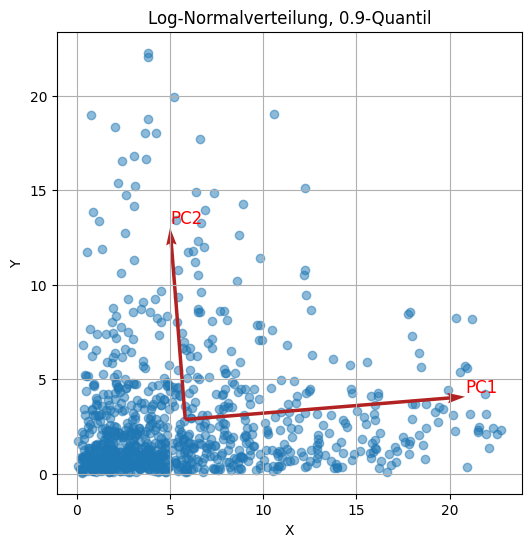

In [15]:
data_quantil = calculate_quantil(data_log, 0.9)
pca_quantil = perform_pca_quantil(data_quantil)
plot_pca_results_qantil(data_quantil, pca_quantil)


### Comparison: logarithmized, lognormal, quantile

In [16]:
def subplot_pca(ln_X, ln_Y, pca, X, Y, pca_lognormal, data_quantil, pca_quantil, quantil):
    fig = plt.figure(figsize=(15, 5))

    # Buchstaben für die Abbildungen
    letters = ['a', 'b', 'c']
    positions = [(0.04, 0.94), (1.1, 0.94), (2.1, 0.94)]  # Position der Buchstaben über den Subplots

    # Buchstaben außerhalb der Subplots platzieren
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=22, fontweight='bold')

    ax1 = fig.add_subplot(131)
    ax1.scatter(ln_X, ln_Y, alpha=0.5)
    for i, (length, vector) in enumerate(zip(pca.explained_variance_, pca.components_)):
        v = vector * np.sqrt(length) * 3
        ax1.quiver(pca.mean_[0], pca.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color='firebrick')
        label = "PC1" if i == 0 else "PC2"
        
        # Basisposition des Labels
        x_text = pca.mean_[0] + v[0]
        y_text = pca.mean_[1] + v[1]
        
        # Nur PC2 leicht nach links verschieben
        if label == "PC2":
            x_text -= 2  # ← nach links
            y_text += 0.5  # optional: etwas höher

        ax1.text(x_text, y_text, label, color='firebrick', fontsize=17, verticalalignment='bottom', fontweight="bold")

    ax1.set_xlabel('log(X)', fontsize="18")
    ax1.set_ylabel('log(Y)', fontsize="18")
    ax1.grid(True)
    ax1.axis('equal')
    ax1.tick_params(axis='both', labelsize=18) 
    ax1.set_xlim(-15, 25)
    ax1.set_ylim(-10, 25)
    ax1.set_xticks(np.arange(-15, 30, 5))

    axins1 = inset_axes(ax1, width=1.5, height=1.5, loc='upper right', bbox_to_anchor=(0.99, 0.95), bbox_transform=ax1.transAxes)
    axins1.bar([1, 2], pca.explained_variance_ratio_, color='gray')
    axins1.set_xticks([1, 2])
    axins1.set_xticklabels(['PC1', 'PC2'], fontsize=16)
    axins1.set_yticks([0.0, 0.5, 1.0])
    axins1.set_yticklabels(['0', '0.5', '1.0'], fontsize=16)
    axins1.set_title("EVR", fontsize=15)

    # ...
    ax2 = fig.add_subplot(132)
    ax2.scatter(X, Y, alpha=0.5)
    for i, (length, vector) in enumerate(zip(pca_lognormal.explained_variance_, pca_lognormal.components_)):
        v = vector * np.sqrt(length) * 3
        ax2.quiver(pca_lognormal.mean_[0] + v[0], pca_lognormal.mean_[1] + v[1], angles='xy', scale_units='xy', scale=1, color='firebrick')
        label = "PC1" if i == 0 else "PC2"
        ax2.text(pca_lognormal.mean_[0] + v[0], pca_lognormal.mean_[1] + v[1], label, color='firebrick', fontsize=13, verticalalignment='bottom', fontweight="bold")
    ax2.set_xlabel('X', fontsize="16")
    ax2.set_ylabel('Y', fontsize="16")
    ax2.grid(True)
    ax2.tick_params(axis='both', labelsize=14) 

    axins2 = inset_axes(ax2, width=1, height=1, loc='upper right', bbox_to_anchor=(0.99, 0.95), bbox_transform=ax2.transAxes)
    axins2.bar([1, 2], pca_lognormal.explained_variance_ratio_, color='gray')
    axins2.set_xticks([1, 2])
    axins2.set_xticklabels(['PC1', 'PC2'], fontsize=12)
    axins2.set_yticks([0.0, 0.5, 1.0])
    axins2.set_yticklabels(['0', '0.5', '1.0'], fontsize=12)
    axins2.set_title("Expl. Variance Ratio", fontsize=12)

    # ...
    ax3 = fig.add_subplot(133)
    ax3.scatter(data_quantil[:,0], data_quantil[:,1], alpha=0.5)
    for i, (length, vector) in enumerate(zip(pca_quantil.explained_variance_, pca_quantil.components_)):
        v = vector * np.sqrt(length) * 3
        ax3.quiver(pca_quantil.mean_[0], pca_quantil.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color='firebrick')
        label = "PC1" if i == 0 else "PC2"
        ax3.text(pca_quantil.mean_[0] + v[0], pca_quantil.mean_[1] + v[1], label, color='firebrick', fontsize=13, verticalalignment='bottom', fontweight="bold")
    ax3.set_xlabel('X', fontsize="16")
    ax3.set_ylabel('Y', fontsize="16")
    ax3.grid(True)
    ax3.tick_params(axis='both', labelsize=14)

    axins3 = inset_axes(ax3, width=1, height=1, loc='upper right', bbox_to_anchor=(0.99, 0.95), bbox_transform=ax3.transAxes)
    axins3.bar([1, 2], pca_quantil.explained_variance_ratio_, color='gray')
    axins3.set_xticks([1, 2])
    axins3.set_xticklabels(['PC1', 'PC2'], fontsize=12)
    axins3.set_yticks([0.0, 0.5, 1.0])
    axins3.set_yticklabels(['0', '0.5', '1.0'], fontsize=12)
    axins3.set_title("Expl. Variance Ratio", fontsize=12)


    plt.tight_layout()
    # plt.savefig("../../latex/figures/4_pca_on_lognormaldata.pdf")
    # plt.savefig("../../latex/pictures/4_pca_on_lognormaldata.png", dpi=300, bbox_inches="tight")
    plt.show()

In [17]:
MU_A, SIGMA_A, MU_B, SIGMA_B = 1, 2.5, 1.3, 3
N = 1000
a, b = 1.4, 1
PHI_GRAD = 25
QUANTIL = 0.9
quantiles = np.arange(100, 0, -10)
# seeds = np.random.randint(1, 1000000, 100)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
C:\Users\emmiw\AppData\Local\Temp\ipykernel_26448\1572075250.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


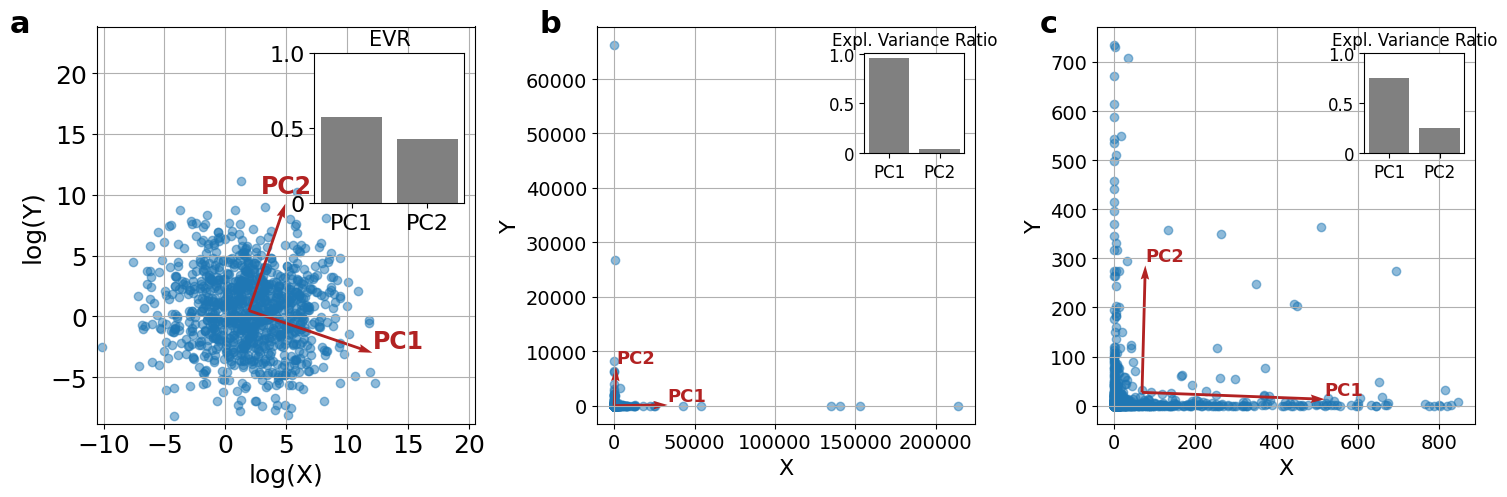

In [18]:
A_log, B_log = generate_A_B(MU_A, SIGMA_A, MU_B, SIGMA_B, N, seed=231003)
phi = np.radians(PHI_GRAD)
X_log, Y_log = generate_X_Y(A_log, B_log, a, b, phi)
X_norm, Y_norm = logarithmize_X_Y(A_log, B_log, a, b, phi)
data_norm, pca_norm = perform_pca(X_norm, Y_norm)
data_log, pca_log = perform_pca(X_log, Y_log)
data_quantil = calculate_quantil(data_log, quantil=0.9)
pca_quantil = perform_pca_quantil(data_quantil)
subplot_pca(X_norm, Y_norm, pca_norm, X_log, Y_log, pca_log, data_quantil, pca_quantil, QUANTIL)

Log-transform is used to reduce the influence of extrem values or outliners.

### Relative count of A and B and their logarithmized values

In [19]:
def relative_count_A_B(A, B):
    fig = plt.figure(figsize=(8, 8))
    bin1 = np.linspace(0, 90, 46) # binsize 2, 45 bins
    bin2 = np.linspace(-2, 3, 26) # binsize 1\5, 25 bins

    letters = ['a', 'b', 'c', 'd']
    positions = [(0.09, 0.97), (1.6, 0.97), (0.09, 0.47), (1.6, 0.47)] 
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=14, fontweight='bold')
        
    # p(a) gegen a
    ax1 = fig.add_subplot(221)
    ax1.hist(A, bins=40, color='blue', edgecolor='black', alpha=0.7, density=True)
    ax1.set_xlabel("A") 
    ax1.set_ylabel("Density of A")
    xa = np.linspace(min(A), max(A), 300)
    shape, loc, scale = lognorm.fit(A, floc=0)
    pdf = lognorm.pdf(xa, shape, loc, scale)
    ax1.plot(xa, pdf, color='orange', label="Analytic Curve", linewidth=1)
    ax1.legend()
    ax1.set_xlim(-2, 90)
    ax1.set_ylim(0, 0.25)

    # p(a) gegen log(a)
    logA = np.log10(A)
    ax2 = fig.add_subplot(222)
    hist, bin_edges = np.histogram(logA, 15, density=True)
    bin_edges = 10**(bin_edges)
    bin_widths = np.diff(bin_edges)
    ax2.bar(bin_edges[:-1], hist, width=bin_widths, align='edge', color='blue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel("A (log scale)")
    ax2.set_ylabel("Density of A")
    x_loga = np.linspace(min(logA), max(logA), 300)
    mu, sigma = np.mean(logA), np.std(logA)
    pdf_log = norm.pdf(x_loga, mu, sigma)
    ax2.plot(10**x_loga, pdf_log, color='orange', linewidth=1)
    ax2.set_xlim(10**-2, 10**3)
    ax2.set_ylim(0, 1)
    ax2.set_xscale('log')

    # p(b) gegen b
    ax3 = fig.add_subplot(223)
    ax3.hist(B, bins=150, color='blue', edgecolor='black', alpha=0.7, density=True)
    ax3.set_xlabel("B")
    ax3.set_ylabel("Density of B")
    xb = np.linspace(min(B), max(B), 300)
    shape, loc, scale = lognorm.fit(B, floc=0)
    pdf = lognorm.pdf(xb, shape, loc, scale)
    ax3.plot(xb, pdf, color='orange', linewidth=1)
    ax3.set_xlim(-2, 90)
    ax3.set_ylim(0, 0.25)

    # p(b) gegen log(b)
    logB = np.log10(B)
    ax4 = fig.add_subplot(224)
    hist, bin_edges = np.histogram(logB, 20, density=True)
    bin_edges = 10**(bin_edges)
    bin_widths = np.diff(bin_edges)
    ax4.bar(bin_edges[:-1], hist, width=bin_widths, align='edge', color='blue', edgecolor='black', alpha=0.7)
    ax4.set_xlabel("B (log scale)")
    ax4.set_ylabel("Density of B")
    x_logb = np.linspace(min(logB), max(logB), 300)
    mu, sigma = np.mean(logB), np.std(logB)
    pdf_log = norm.pdf(x_logb, mu, sigma)
    ax4.plot(10**x_logb, pdf_log, color='orange', linewidth=1)
    ax4.set_xlim(10**-2, 10**3)
    ax4.set_ylim(0, 1)
    ax4.set_xscale('log')

    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.3, hspace=0.3)
    # plt.savefig("../../latex/figures/5_relative_frequencies_AB.pdf", bbox_inches='tight')
    # plt.savefig("../../latex/pictures/5_relative_frequencies_AB.png", dpi=400, bbox_inches='tight')
    plt.show()

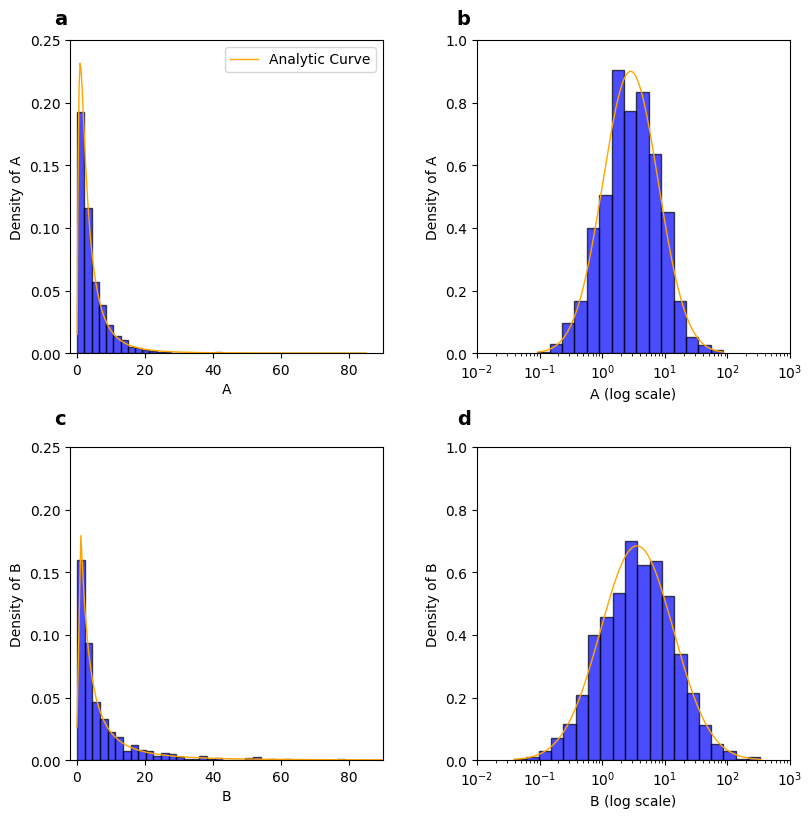

In [20]:
MU_A, SIGMA_A, MU_B, SIGMA_B = 1, 1, 1.3, 1.3
A_log, B_log = generate_A_B(MU_A, SIGMA_A, MU_B, SIGMA_B, N, seed=231003)
relative_count_A_B(A_log, B_log)

Note that in Figure c, eight outliers were excluded to prevent excessive distortion of the visualization, which would have compromised the comparability with Figure a.


## Analysis of quantile effect

In [21]:
# explained variance for different quantiles for PC1
def explained_variance_for_quantiles(mu_a, sigma_a, mu_b, sigma_b, a, b, phi, quantiles, seeds, n):
    explained_variances_pc1 = np.zeros((len(seeds), len(quantiles)))
    for i, seed in enumerate(seeds):
        np.random.seed(seed)  # Setze den aktuellen Seed
        
        # Generiert A, B, X und Y für jedes Seed
        A, B = generate_A_B(mu_a, sigma_a, mu_b, sigma_b, n, seed)
        X, Y = generate_X_Y(A, B, a, b, phi)
        
        for j, quantil in enumerate(quantiles):
            data_quantil = calculate_quantil(np.array([X, Y]).T, quantil / 100.0)
            pca_quantil = perform_pca_quantil(data_quantil)
            explained_variances_pc1[i, j] = pca_quantil.explained_variance_ratio_[0]  

    mean_variance = np.mean(explained_variances_pc1, axis=0) * 100
    std_variance = np.std(explained_variances_pc1, axis=0) *100
    return explained_variances_pc1, mean_variance, std_variance

def plot_expl_variance_seed(quantiles, mean_variance, std_variance):
    plt.figure(figsize=(8, 6))
    plt.plot(quantiles, mean_variance, marker='o', ls='--', color='blue', label='Mean EVR (PC1)')
    plt.fill_between(quantiles, mean_variance - std_variance, mean_variance + std_variance, color='skyblue', alpha=0.5, label='± Noise')
    plt.xlabel('Quantile [%]')
    plt.ylabel('Explained Variance Ratio (PC1) [%]')
    # plt.title('Explained Variance with Quantiles and Noise')
    plt.gca().invert_xaxis()  
    plt.xticks(quantiles)
    plt.yticks(np.arange(0, 110, 10))
    plt.xlim(100, 10)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    # plt.savefig("../../latex/figures/6_explained_variance_ratio_seeds.pdf")
    # plt.savefig("../../latex/pictures/6_explained_variance_ratio_seeds.png", dpi=400, bbox_inches="tight")
    plt.show()


In [22]:
MU_A, SIGMA_A, MU_B, SIGMA_B = 1, 2.5, 1.3, 3
N = 1000
SEED = 231003
QUANTIL = 0.9
a, b = 1.4, 1
PHI_GRAD = 25
phi = np.radians(PHI_GRAD)
quantiles = np.arange(100, 0, -10)
seeds = np.random.randint(1, 1000000, 100)


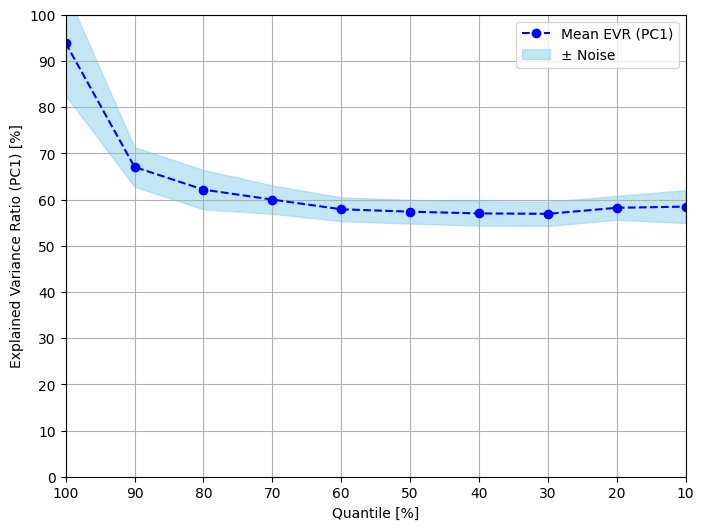

In [23]:
explained_variances_pc1, mean_variance, std_variance = explained_variance_for_quantiles(MU_A, SIGMA_A, MU_B, SIGMA_B, a, b, phi, quantiles, seeds, N)
plot_expl_variance_seed(quantiles, mean_variance, std_variance)

In [24]:
# angle pc1 and x-axis
def calculate_angle_from_pc(pca):
    pc1 = pca.components_[0]
    angle = np.arctan2(pc1[1], pc1[0]) 
    return angle

# angle for different seeds and quantiles
def angle_for_quantiles(mu_a, sigma_a, mu_b, sigma_b, a, b, phi, quantiles, seeds, n):
    angles = np.zeros((len(seeds), len(quantiles)))
    for i, seed in enumerate(seeds):
        np.random.seed(seed) 
        
        # generate A, B, X and Y for each seed
        A, B = generate_A_B(mu_a, sigma_a, mu_b, sigma_b, n, seed)
        X, Y = generate_X_Y(A, B, a, b, phi)
        
        for j, quantil in enumerate(quantiles):
            data_quantil = calculate_quantil(np.array([X, Y]).T, quantil / 100.0)
            pca_quantil = perform_pca_quantil(data_quantil)
            angles[i, j] = calculate_angle_from_pc(pca_quantil) 
    return angles

angles = angle_for_quantiles(MU_A, SIGMA_A, MU_B, SIGMA_B, a, b, phi, quantiles, seeds, N)

# mean and stdv 
mean_angle = np.mean(angles, axis=0)
std_angle = np.std(angles, axis=0)

In [25]:
def plot_angle_PC1_Xaxis(quantiles, mean_angle, std_angle):
    plt.figure(figsize=(8, 6))
    plt.plot(quantiles, mean_angle, marker='o', ls='--', color='blue', label='Mean angle ϑ')
    plt.fill_between(quantiles, mean_angle - std_angle, mean_angle + std_angle, color='skyblue', alpha=0.5, label='± Noise')
    plt.ylim(-np.pi, np.pi) 
    plt.yticks(np.linspace(-np.pi, np.pi, 5), labels=['-π', '-π/2', '0', 'π/2', 'π']) 
    plt.xlabel('Quantile [%]')
    plt.ylabel('Principal component angle ϑ [rad]')
    # plt.title('Angle between PC1 and X-Axis in different Quantiles')
    plt.gca().invert_xaxis()
    plt.xlim(100, 10)
    plt.xticks(quantiles)
    plt.grid(True)
    plt.legend()
    plt.savefig("../../latex/figures/7_angle_axis_pc1_quantile.pdf")
    plt.savefig("../../latex/pictures/7_angle_axis_pc1_quantile.png", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"The mean angle between x-axis and pc1 are {np.degrees(mean_angle)}")

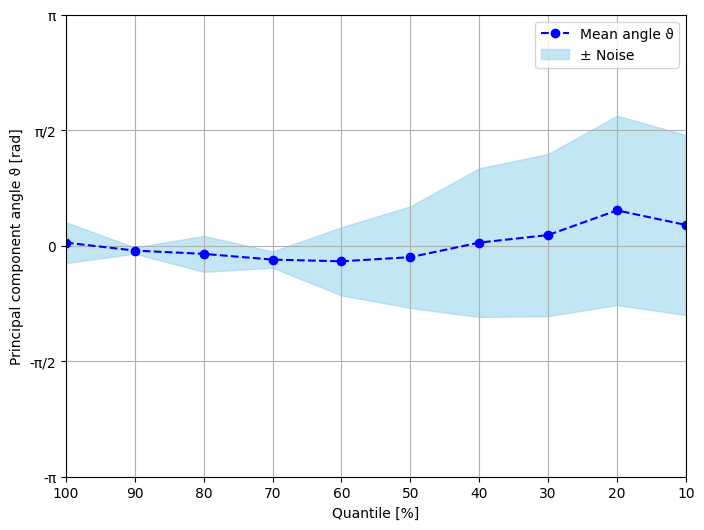

The mean angle between x-axis and pc1 are [  2.41574746  -3.79019579  -6.33671711 -10.81118896 -12.14166808
  -8.91008659   2.41532506   8.32637346  27.55445553  16.15404327]


In [26]:
plot_angle_PC1_Xaxis(quantiles, mean_angle, std_angle)

In [27]:
def plot_pca_variance_and_angle_subplots(mu_a, sigma_a, mu_b, sigma_b, a, b, phi, quantiles, seeds, n):
    def calculate_angle_from_pc(pca):
        pc1 = pca.components_[0]
        return np.arctan2(pc1[1], pc1[0])

    def angle_for_quantiles():
        angles = np.zeros((len(seeds), len(quantiles)))
        for i, seed in enumerate(seeds):
            np.random.seed(seed)
            A, B = generate_A_B(mu_a, sigma_a, mu_b, sigma_b, n, seed)
            X, Y = generate_X_Y(A, B, a, b, phi)
            for j, quantil in enumerate(quantiles):
                data_quantil = calculate_quantil(np.array([X, Y]).T, quantil / 100.0)
                pca_quantil = perform_pca_quantil(data_quantil)
                angles[i, j] = calculate_angle_from_pc(pca_quantil)
        return angles

    def explained_variance_for_quantiles():
        explained = np.zeros((len(seeds), len(quantiles)))
        for i, seed in enumerate(seeds):
            np.random.seed(seed)
            A, B = generate_A_B(mu_a, sigma_a, mu_b, sigma_b, n, seed)
            X, Y = generate_X_Y(A, B, a, b, phi)
            for j, quantil in enumerate(quantiles):
                data_quantil = calculate_quantil(np.array([X, Y]).T, quantil / 100.0)
                pca_quantil = perform_pca_quantil(data_quantil)
                explained[i, j] = pca_quantil.explained_variance_ratio_[0]
        return explained

    # Berechne Werte
    angles = angle_for_quantiles()
    explained_variances_pc1 = explained_variance_for_quantiles()

    mean_angle = np.mean(angles, axis=0)
    std_angle = np.std(angles, axis=0)
    mean_variance = np.mean(explained_variances_pc1, axis=0) * 100
    std_variance = np.std(explained_variances_pc1, axis=0) * 100

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    plt.subplots_adjust(wspace=0.3)

    # Buchstaben für die Abbildungen
    letters = ['a', 'b']
    positions = [(0.01, 0.96), (1.54, 0.96)]  # Position der Buchstaben über den Subplots

    # Buchstaben außerhalb der Subplots platzieren
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=19, fontweight='bold')


    # Explained Variance Subplot
    axs[0].plot(quantiles, mean_variance, marker='o', ls='--', color='green', label='Mean EVR (PC1)')
    axs[0].fill_between(quantiles, mean_variance - std_variance, mean_variance + std_variance,
                        color='lightgreen', alpha=0.5, label='± std. dev')
    axs[0].invert_xaxis()
    axs[0].set_xlabel('Quantile [%]', fontsize=19)
    axs[0].set_ylabel('Explained Variance Ratio (PC1) [%]', fontsize=19)
    axs[0].set_xticks(quantiles)
    axs[0].set_yticks(np.arange(0, 110, 10))
    axs[0].set_xlim(100, 10)
    axs[0].set_ylim(0, 100)
    axs[0].tick_params(labelsize=18)
    axs[0].grid(True)
    axs[0].legend(fontsize=16)

    # Angle Subplot
    axs[1].plot(quantiles, mean_angle, marker='o', ls='--', color='blue', label='Mean angle ϑ')
    axs[1].fill_between(quantiles, mean_angle - std_angle, mean_angle + std_angle,
                        color='skyblue', alpha=0.5, label='± std. dev')
    axs[1].set_ylim(-np.pi, np.pi)
    axs[1].set_yticks(np.linspace(-np.pi, np.pi, 5))
    axs[1].set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    axs[1].set_xlabel('Quantile [%]', fontsize=19)
    axs[1].set_ylabel('Principal component angle ϑ [rad]', fontsize=19)
    axs[1].invert_xaxis()
    axs[1].set_xlim(100, 10)
    axs[1].set_xticks(quantiles)
    axs[1].tick_params(labelsize=18)
    axs[1].grid(True)
    axs[1].legend(fontsize=16)


    plt.tight_layout()
    plt.savefig("../../latex/figures/13_subplot_quantiles.pdf")
    plt.savefig("../../latex/pictures/13_subplot_quantiles.png", dpi=300, bbox_inches="tight")
    plt.show()

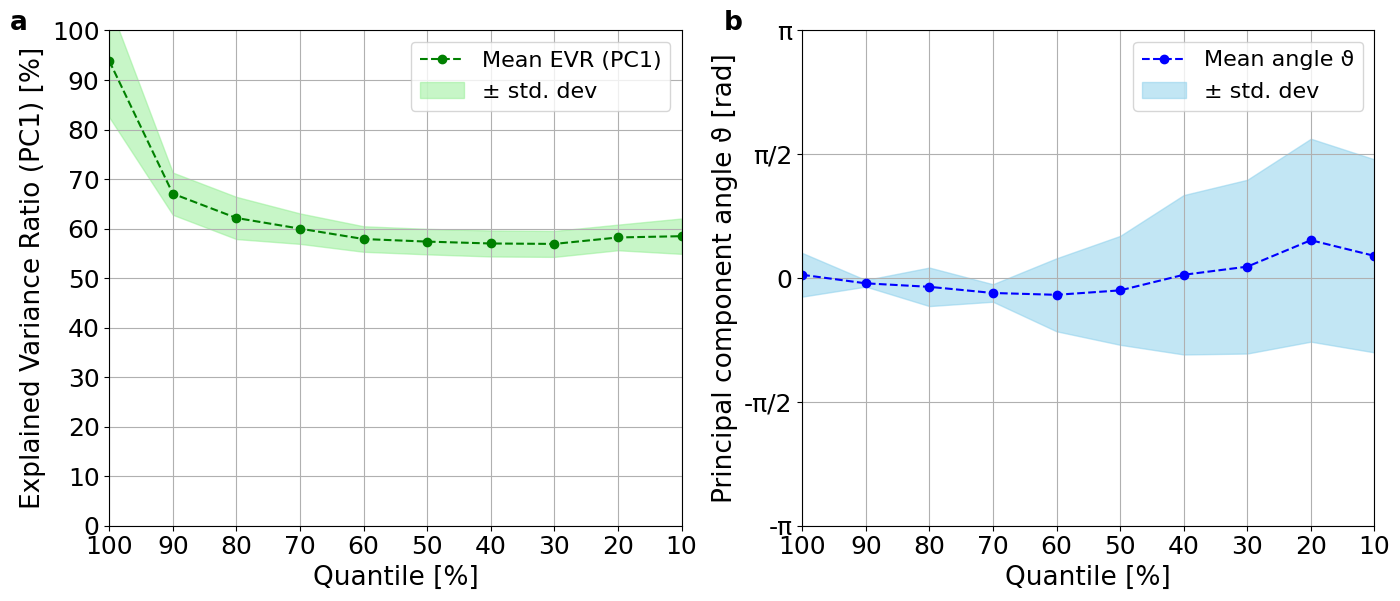

In [28]:
plot_pca_variance_and_angle_subplots(
    mu_a=MU_A,
    sigma_a=SIGMA_A,
    mu_b=MU_B,
    sigma_b=SIGMA_B,
    a=a,
    b=b,
    phi=phi,
    quantiles=quantiles,
    seeds=seeds,
    n=N
)
